# Load and clean up traffic light data

In [12]:
import json

with open('Traffic Lights.json', 'r') as f:
    data = json.load(f)


In [13]:
# Don't include any ramp meters
lights = [light for light in data['elements'] if light['tags'].get('traffic_signals') != 'ramp_meter']
data['elements'] = lights

In [ ]:
import requests
import time

def get_streets(lat, lon):
    api_key = '6625571d10da4926864985dug5dbcca'  

    # Get surrounding points
    delta = 0.00015
    points = [(lat, lon),
              (lat+delta, lon),
              (lat-delta, lon),
              (lat, lon+delta),
              (lat, lon-delta)]
    
    streets = []
    for point in points:
        # Send HTTP Request
        url = f"https://geocode.maps.co/reverse?lat={point[0]}&lon={point[1]}&api_key={api_key}"
        response = requests.get(url)
        time.sleep(1) # Free rate limit of 1 request per second

        # Extract road information
        if response.status_code == 200:
            data = response.json()
            street = data['address'].get('road')
            if street:
                streets.append(street)
        else:
            print(f"Error: {response.status_code}")
    
    # Return the intersection the light lies on
    return list(set(streets))

def query_traffic_light(data, index):
    # Get latitude and longitude
    traffic_light = data['elements'][index]
    lat, lon = traffic_light['lat'], traffic_light['lon']
    
    # Don't waste time if there's already an intersection defined
    if traffic_light.get('intersection'):
        print(f'Light {i}: ({lat}, {lon}) has an intersection')
        return
    
    # Get street names
    print(f'Light {i}: Querying ({lat}, {lon})')
    streets = get_streets(lat, lon)
    traffic_light['intersection'] = streets

    # Write to JSON file
    with open("Traffic Lights.json", "w") as outfile:
        json.dump(data, outfile, indent=4)

# Get intersection for each light
# total_lights = len(data['elements'])
# for i in range(total_lights):
#     query_traffic_light(data, i)

In [40]:
# Explore the data, find all lights with a certain amount of intersections
filtered_lights = [light for light in lights if len(light['intersection'])>3]

for light in filtered_lights:
    print(light['lat'], ",", light['lon'], ':', light['intersection'])

41.9546336 , -87.6452346 : ['North Marine Drive', 'West Irving Park Road', 'North Lake Shore Drive']
41.9252911 , -87.6584642 : ['North Racine Avenue', 'West Fullerton Avenue', 'North Clifton Avenue']
41.9325569 , -87.658713 : ['West Diversey Parkway', 'North Racine Avenue', 'North Lincoln Avenue']
41.8782108 , -87.6276919 : ['East Jackson Boulevard', 'West Jackson Boulevard', 'South State Street']
41.8768125 , -87.636629 : ['South Lower Wacker Drive', 'West Van Buren Street', 'South Upper Wacker Drive']
41.87701 , -87.6243796 : ['East Van Buren Street', 'Grant Park South Garage (Exit)', 'South Michigan Avenue']
41.8769665 , -87.6241746 : ['East Van Buren Street', 'Pedway', 'South Michigan Avenue']
41.8769377 , -87.6276645 : ['East Van Buren Street', 'West Van Buren Street', 'South State Street']
41.8780828 , -87.6369343 : ['South Lower Wacker Service Drive', 'West Jackson Boulevard', 'South Upper Wacker Drive']
41.8984693 , -87.6181914 : ['East Chestnut Street', 'North Jean Baptiste P

# Make connected graph

In [159]:
import math
import networkx as nx

# Get data
with open('Traffic Lights.json', 'r') as f:
    data = json.load(f)
lights = data['elements']


# Initial population of the graph
G = nx.Graph()
graph = {}
for light in lights:
    G.add_node(light['id'], 
               pos=(light['lon'], light['lat']),
               lat=light['lat'], 
               lon=light['lon'],
               intersections=light['intersection'])
    
    graph[light['id']] = {
        'lat': light['lat'],
        'lon': light['lon'],
        'intersection': light['intersection'],
        'connections': []
    }

In [160]:
# Connect lights that share a street
def dist_metric(light1, light2):
    max_dist =  0.22074580639018443
    dist = math.dist([light1['lat'], light1['lon']], [light2['lat'], light2['lon']])
    
    return dist/max_dist

for curr_light in lights:
    curr_id = curr_light['id']

    # Go through each light
    for light in lights:
        # Don't compare to itself
        if light['id'] == curr_id:
            continue

        # Check if the lights share a street
        if not set(light['intersection']).isdisjoint(curr_light['intersection']):
            G.add_edge(curr_id, light['id'], weight=dist_metric(curr_light, light))

In [161]:
def node_weight(G, node_id):
    # Initialize a list to store weights of edges connected to the node
    weights = []

    # Iterate over all edges connected to the node
    for neighbor in G.neighbors(node_id):
        # Access the weight of the edge between node_id and neighbor
        weight = G.edges[node_id, neighbor]['weight']
        weights.append(weight)
        
    # Calculate the average of weights
    if len(weights) == 0:
        return 1

    average_weight = sum(weights) / len(weights)
    return average_weight

for node_id in G.nodes():
    # Calculate the weight for the current node
    weight = node_weight(G, node_id)
    # Update the 'weight' attribute of the node
    G.nodes[node_id]['weight'] = weight

In [165]:
# Order edges based on weight (for exploration)
x = sorted(G.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)
x[0]

(33754414, 261170509, {'weight': 1.0})

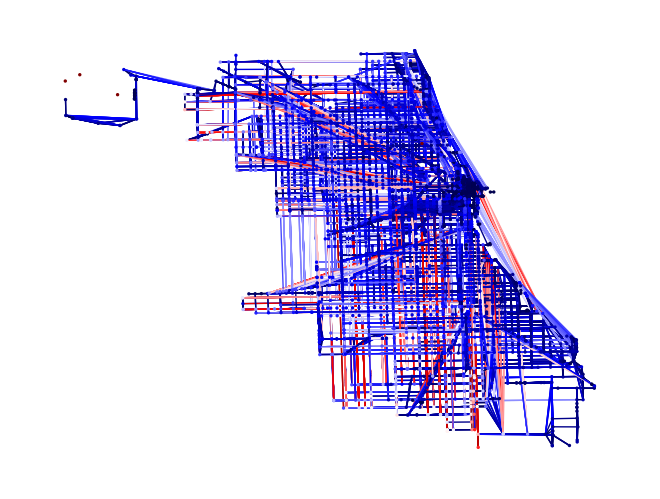

In [166]:
import matplotlib.pyplot as plt

# Get edge and node weights
edges,e_weights = zip(*nx.get_edge_attributes(G,'weight').items())
nodes,n_weights = zip(*nx.get_node_attributes(G,'weight').items())
pos=nx.get_node_attributes(G,'pos')

# Draw and save graph
nx.draw(G, pos, 
        node_color=n_weights, node_size=2, cmap=plt.cm.seismic,
        edge_color=e_weights, edge_cmap=plt.cm.seismic)
plt.savefig("graph.png", dpi=1000)